In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

# Depth from Defocus

In [7]:
def gaussian_kernel(x, y, sigma):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

def gaussian_kernel_gradient(x, y, sigma):
    kernel = gaussian_kernel(x, y, sigma)
    return kernel * ((x**2 + y**2) / sigma**3 - 2 / sigma)

def compute_gradient_sigma(I, g, h, x, y):
    
    k_h, k_w = h.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    region = I[max(0, x - pad_h):x + pad_h + 1, max(0, y - pad_w):y + pad_w + 1]
    
    region_padded = np.zeros_like(h)
    start_x = max(0, pad_h - x)
    start_y = max(0, pad_w - y)
    end_x = start_x + region.shape[0]
    end_y = start_y + region.shape[1]
    region_padded[start_x:end_x, start_y:end_y] = region

    I_h_xy = np.sum(region_padded * h)

    residual_xy = g[x, y] - I_h_xy

    h_flipped = np.flip(h)
    grad_xy = -2 * residual_xy * h_flipped[pad_h, pad_w]

    return grad_xy

def compute_gradient_image(I, g, h, x, y):
    
    k_h, k_w = h.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    region = I[max(0, x - pad_h):x + pad_h + 1, max(0, y - pad_w):y + pad_w + 1]
    
    padded_region = np.zeros_like(h)
    start_x = max(0, pad_h - x)
    start_y = max(0, pad_w - y)
    end_x = start_x + region.shape[0]
    end_y = start_y + region.shape[1]
    padded_region[start_x:end_x, start_y:end_y] = region

    I_h_xy = np.sum(padded_region * h)

    residual_xy = g[x, y] - I_h_xy

    h_flipped = np.flip(h)

    grad_xy = -2 * residual_xy * h_flipped[pad_h, pad_w]

    return grad_xy

def get_kernel(K, sigma):
    
    if K % 2 == 0:
        raise ValueError("K must be an odd number for a centered kernel.")
    
    center = K // 2
    x = np.arange(-center, center + 1)
    y = np.arange(-center, center + 1)
    X, Y = np.meshgrid(x, y)

    kernel = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    kernel /= np.sum(kernel)

    return kernel

In [40]:
def optimal_params(g1, g2, D1, D2):
    num_steps = 50
    lr = 1e-1
    lr_decay = 0.99

    Sigma = np.ones_like(g1)
    I = np.ones_like(g1) * 0.5

    for _ in tqdm(range(num_steps)):

        sigma_gradient = np.zeros_like(I)
        image_gradient = np.zeros_like(I)

        for x in range(g1.shape[0]):
            for y in range(g2.shape[1]):

                h1 = get_kernel(K = 5, sigma=Sigma[x, y])
                h2 = get_kernel(K = 5, sigma= (D2 / D1) * Sigma[x, y])

                sigma_gradient[x, y] = compute_gradient_sigma(I, g1, h1, x, y) + (D2 / D1) * compute_gradient_sigma(I, g2, h2, x, y)               
                image_gradient[x, y] = compute_gradient_image(I, g1, h1, x, y) + compute_gradient_image(I, g2, h2, x, y)

        Sigma = Sigma - lr * sigma_gradient
        I = I - lr * image_gradient
        lr *= lr_decay
    
    return I, Sigma

(1000, 1332)


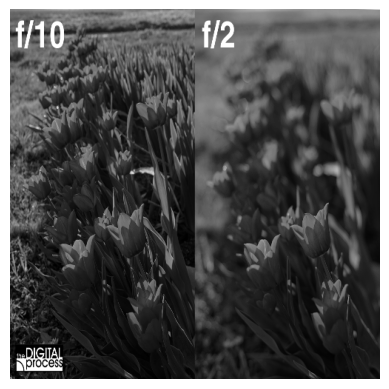

In [54]:
path = "/home/arnabdey/Placement_ML_projects/Depth From Defocus/2 Apertures.jpg"
dual_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY) / 255.0
print(dual_image.shape)
dual_image = cv2.resize(dual_image, (500, 500))
h, w = dual_image.shape
plt.imshow(dual_image, cmap='gray')
plt.axis('off')
plt.show()

In [42]:
g1 = dual_image[:, :w//2]
g2 = dual_image[:, w//2:]
f = 25.0 / 1000.0
D1, D2 = f / 10.0, f / 2.0
I, sigma = optimal_params(g1=g1, g2=g2, D1=D2, D2=D2)

100%|██████████| 50/50 [12:36<00:00, 15.13s/it]


In [66]:
Sigma = (sigma - np.min(sigma)) / (np.max(sigma) - np.min(sigma))
b = 2 * Sigma
s = 2
num = s * f
den = s - f + b * (f / D1)
o = num / den

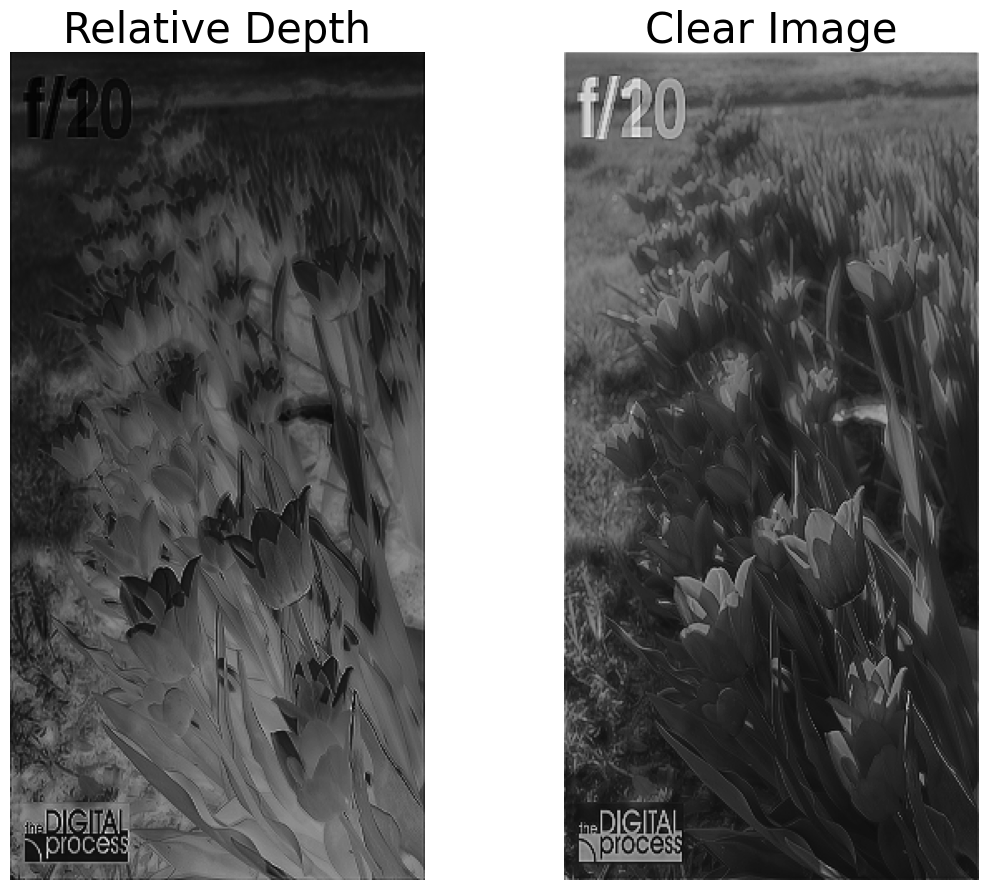

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 9))

axes[0].imshow(o, cmap='gray')
axes[0].set_title("Relative Depth", fontsize=30)
# Display the second image
axes[1].imshow(I, cmap='gray')
axes[1].set_title("Clear Image", fontsize=30)

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()
